In [1]:
import os
#Needed for deterministic behavior
#os.environ["CUBLAS_WORKSPACE_CONFIG"]= ":16:8"
#os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

!pip install -q -r requirements.txt

In [2]:
%matplotlib inline

#import pytorch-fid
import time
import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch.autograd import Variable
import os 
import sys
from PIL import Image

In [3]:
class MLPGenerator(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP generator"""
        
        super().__init__()
        self.label_emb = torch.nn.Embedding(2,2)
        assert number_of_hidden_layers >= 0, "Generator number_of_hidden_layers must be at least 0"
        
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        # final output should be the size of a true example
        dims_out = [hidden_size] * number_of_hidden_layers + [output_size] 
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply Sigmoid after final layer to constrain generated images to [0, 1]
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor, labels):
        c = self.label_emb(labels)
        xx = torch.cat([z,c],1)
        return self.net(xx)

class MLPDiscriminator(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 activation: torch.nn.Module):
        """Construct a simple MLP discriminator"""
        
        super().__init__()
        self.label_emb = torch.nn.Embedding(2,2)
        msg = "Discriminator number_of_hidden_layers must be at least 0"
        assert number_of_hidden_layers >= 0, msg
        
        # final output dimension is scalar (probability image is real)
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [1]
        
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply sigmoid after final layer to represent probability
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor, labels):
        c = self.label_emb(labels)
        xx = torch.cat([x,c],1)
        return self.net(xx)

class Model(torch.nn.Module):
    def __init__(self,
                 number_of_hidden_layers: int, 
                 latent_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation_generator: torch.nn.Module = torch.nn.ReLU(),
                 activation_discriminator: torch.nn.Module = torch.nn.LeakyReLU(0.2)
                ):
        
        super().__init__()
                          
        self.generator = MLPGenerator(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=latent_size+2, 
            hidden_size=hidden_size, 
            output_size=output_size,
            activation=activation_generator
        )
        
        self.discriminator = MLPDiscriminator(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=output_size+2, 
            hidden_size=hidden_size,
            activation=activation_discriminator
        )

In [4]:
def load_data(batch_size: int = 128):
    """
    Load dataset.
    :return: DataLoader object
    """

    cuda_kwargs = {
        'num_workers': 1,
        'pin_memory': True,
        'shuffle': True
    } if torch.cuda.is_available() else {}

    # format image data, but do not normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])
    path = "image_data/cleaned_train"
    dataset = datasets.ImageFolder(path,transform)
    # load data
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        **cuda_kwargs
    )
    return loader

In [5]:
# Training hyperparameters that you shouldn't need to change.
# Consider changing batch size only if you are trying to speed up your training.
image_size = 128 #28
batch_size = 64

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is",device)

# load MNIST dataset
mnist = load_data(batch_size=batch_size)

# discriminator loss function: binary cross-entropy loss
discrim_loss_func = torch.nn.BCELoss()

# determine which labels will correspond to "real" and "fake" predictions from the discriminator
label_real = 1.0
label_fake = 0.0

Device is cuda


In [6]:
    # Training hyperparameters
    hidden_size = 4096
    number_of_hidden_layers = 4
    learning_rate = 0.0000025
    epochs = 1000
    latent_size = 100

In [7]:
# fix random seed
np.random.seed(1)
torch.manual_seed(1)
#torch.use_deterministic_algorithms(True)

# initialize the model
model = Model(
    number_of_hidden_layers=number_of_hidden_layers, 
    latent_size=latent_size, 
    hidden_size=hidden_size, 
    output_size=image_size*image_size, 
).to(device)

# log metrics
loss_d = np.zeros(epochs)
loss_g = np.zeros(epochs)

optimizer_discriminator = torch.optim.Adam(model.discriminator.parameters(), lr=learning_rate)
optimizer_generator = torch.optim.Adam(model.generator.parameters(), lr=learning_rate)

print("Starting Training!")
startTime = time.time()
for epoch in range(epochs):
    total_epoch_size = 0

    for batch_idx, batch_data in enumerate(mnist):

        x_real, y_real = batch_data
        
        # flatten input images and move to device
        x_real = x_real.to(device)
        y_real = y_real.to(device)
        n_batch = x_real.shape[0]
        x_real = x_real.reshape(n_batch, -1)

        # TODO: write your training code here to compute loss functions
        #   and use optimizer(s) to update your parameters
        loss_discriminator = torch.tensor(0)
        loss_generator = torch.tensor(0)

         # Train discriminator
        optimizer_discriminator.zero_grad()

        # Generate fake images
        z = torch.randn(n_batch, latent_size).to(device)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, n_batch))).to(device)
        x_fake = model.generator(z, fake_labels).to(device)

        # Compute discriminator loss for real and fake images
        y_real_pred = model.discriminator(x_real, y_real)
        y_fake_pred = model.discriminator(x_fake.detach(),fake_labels)

        loss_real = discrim_loss_func(y_real_pred, torch.full((n_batch, 1), label_real).to(device))
        loss_fake = discrim_loss_func(y_fake_pred, torch.full((n_batch, 1), label_fake).to(device))
        loss_discriminator = (loss_real + loss_fake)
        
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Train generator
        optimizer_generator.zero_grad()

        # Generate fake images again and compute generator loss
        y_fake_pred = model.discriminator(x_fake.detach(), fake_labels)
        loss_generator = discrim_loss_func(y_fake_pred, torch.full((n_batch, 1), label_real).to(device))

        loss_generator.backward()
        optimizer_generator.step()

        # Train generator again for n times
        num_repeat = 1
        for i in range(num_repeat):
            optimizer_generator.zero_grad()

            # Generate fake images again and compute generator loss
            y_fake_pred = model.discriminator(x_fake, fake_labels)
            loss_generator = discrim_loss_func(y_fake_pred, torch.full((n_batch, 1), label_real).to(device))

            loss_generator.backward()
            optimizer_generator.step()

        # Encode and decode real images
        #z_encoded = model.encoder(x_real)
        #x_decoded = model.generator(z_encoded)
        
        # log losses and scores
        loss_d[epoch] += loss_discriminator.detach().item() * n_batch
        loss_g[epoch] += loss_generator.detach().item() * n_batch
        total_epoch_size += n_batch

    loss_d[epoch] /= total_epoch_size
    loss_g[epoch] /= total_epoch_size

    #if epoch == 0 or (epoch + 1) % max(1, epochs // 10) == 0:
    total = loss_g[epoch] + loss_d[epoch]
    duration = round(time.time() - startTime)
    log = "  ".join([
        f"Epoch: {epoch + 1:4d}",
        f"Gen Loss: {loss_g[epoch]:8.1f}",
        f"Dis Loss: {loss_d[epoch]:8.1f}",
        f"Total: {total:8.1f}",
        f"Time: {(duration//3600):02.0f}:{((duration%3600)//60):02.0f}:{(duration%60):02.0f}"
    ])
    print(log)

Starting Training!
Epoch:    1  Gen Loss:      0.9  Dis Loss:      1.0  Total:      1.9  Time: 00:00:10
Epoch:    2  Gen Loss:      1.1  Dis Loss:      1.0  Total:      2.1  Time: 00:00:19
Epoch:    3  Gen Loss:      0.9  Dis Loss:      1.4  Total:      2.3  Time: 00:00:27
Epoch:    4  Gen Loss:      0.9  Dis Loss:      1.1  Total:      1.9  Time: 00:00:35
Epoch:    5  Gen Loss:      1.0  Dis Loss:      1.1  Total:      2.1  Time: 00:00:44
Epoch:    6  Gen Loss:      0.8  Dis Loss:      1.3  Total:      2.1  Time: 00:00:52
Epoch:    7  Gen Loss:      1.2  Dis Loss:      0.9  Total:      2.1  Time: 00:01:00
Epoch:    8  Gen Loss:      1.5  Dis Loss:      0.8  Total:      2.3  Time: 00:01:09
Epoch:    9  Gen Loss:      1.6  Dis Loss:      0.7  Total:      2.3  Time: 00:01:17
Epoch:   10  Gen Loss:      1.6  Dis Loss:      0.7  Total:      2.4  Time: 00:01:25
Epoch:   11  Gen Loss:      2.3  Dis Loss:      0.4  Total:      2.7  Time: 00:01:34
Epoch:   12  Gen Loss:      1.8  Dis Loss:    

Epoch:   98  Gen Loss:      1.3  Dis Loss:      0.9  Total:      2.2  Time: 00:13:30
Epoch:   99  Gen Loss:      1.3  Dis Loss:      0.9  Total:      2.2  Time: 00:13:38
Epoch:  100  Gen Loss:      1.2  Dis Loss:      1.1  Total:      2.3  Time: 00:13:47
Epoch:  101  Gen Loss:      1.3  Dis Loss:      1.1  Total:      2.4  Time: 00:13:55
Epoch:  102  Gen Loss:      1.3  Dis Loss:      1.1  Total:      2.4  Time: 00:14:03
Epoch:  103  Gen Loss:      1.4  Dis Loss:      1.1  Total:      2.5  Time: 00:14:11
Epoch:  104  Gen Loss:      1.6  Dis Loss:      1.1  Total:      2.7  Time: 00:14:19
Epoch:  105  Gen Loss:      1.7  Dis Loss:      1.0  Total:      2.7  Time: 00:14:28
Epoch:  106  Gen Loss:      1.5  Dis Loss:      1.1  Total:      2.6  Time: 00:14:36
Epoch:  107  Gen Loss:      1.5  Dis Loss:      1.2  Total:      2.7  Time: 00:14:44
Epoch:  108  Gen Loss:      1.9  Dis Loss:      0.8  Total:      2.7  Time: 00:14:52
Epoch:  109  Gen Loss:      1.7  Dis Loss:      0.8  Total:      

Epoch:  195  Gen Loss:      1.4  Dis Loss:      1.0  Total:      2.5  Time: 00:26:45
Epoch:  196  Gen Loss:      1.5  Dis Loss:      1.0  Total:      2.6  Time: 00:26:53
Epoch:  197  Gen Loss:      1.6  Dis Loss:      1.0  Total:      2.6  Time: 00:27:02
Epoch:  198  Gen Loss:      1.5  Dis Loss:      1.2  Total:      2.7  Time: 00:27:10
Epoch:  199  Gen Loss:      1.7  Dis Loss:      1.1  Total:      2.8  Time: 00:27:18
Epoch:  200  Gen Loss:      1.7  Dis Loss:      0.9  Total:      2.7  Time: 00:27:26
Epoch:  201  Gen Loss:      1.4  Dis Loss:      1.2  Total:      2.6  Time: 00:27:34
Epoch:  202  Gen Loss:      1.6  Dis Loss:      1.2  Total:      2.8  Time: 00:27:43
Epoch:  203  Gen Loss:      1.6  Dis Loss:      1.7  Total:      3.3  Time: 00:27:51
Epoch:  204  Gen Loss:      1.5  Dis Loss:      1.1  Total:      2.5  Time: 00:27:59
Epoch:  205  Gen Loss:      1.4  Dis Loss:      1.0  Total:      2.4  Time: 00:28:08
Epoch:  206  Gen Loss:      1.4  Dis Loss:      1.0  Total:      

Epoch:  292  Gen Loss:      1.8  Dis Loss:      0.7  Total:      2.6  Time: 00:40:01
Epoch:  293  Gen Loss:      1.9  Dis Loss:      0.7  Total:      2.6  Time: 00:40:09
Epoch:  294  Gen Loss:      1.9  Dis Loss:      0.7  Total:      2.6  Time: 00:40:17
Epoch:  295  Gen Loss:      1.9  Dis Loss:      0.7  Total:      2.5  Time: 00:40:26
Epoch:  296  Gen Loss:      1.8  Dis Loss:      0.8  Total:      2.6  Time: 00:40:34
Epoch:  297  Gen Loss:      1.8  Dis Loss:      0.8  Total:      2.6  Time: 00:40:42
Epoch:  298  Gen Loss:      1.8  Dis Loss:      0.8  Total:      2.7  Time: 00:40:50
Epoch:  299  Gen Loss:      1.8  Dis Loss:      0.8  Total:      2.6  Time: 00:40:58
Epoch:  300  Gen Loss:      1.8  Dis Loss:      0.8  Total:      2.6  Time: 00:41:07
Epoch:  301  Gen Loss:      1.8  Dis Loss:      0.8  Total:      2.6  Time: 00:41:15
Epoch:  302  Gen Loss:      1.9  Dis Loss:      0.8  Total:      2.6  Time: 00:41:23
Epoch:  303  Gen Loss:      2.0  Dis Loss:      0.7  Total:      

Epoch:  389  Gen Loss:      2.4  Dis Loss:      0.6  Total:      3.0  Time: 00:53:34
Epoch:  390  Gen Loss:      2.2  Dis Loss:      0.7  Total:      2.9  Time: 00:53:43
Epoch:  391  Gen Loss:      2.2  Dis Loss:      0.7  Total:      3.0  Time: 00:53:51
Epoch:  392  Gen Loss:      2.2  Dis Loss:      0.8  Total:      3.0  Time: 00:53:59
Epoch:  393  Gen Loss:      2.4  Dis Loss:      0.7  Total:      3.1  Time: 00:54:08
Epoch:  394  Gen Loss:      2.4  Dis Loss:      0.7  Total:      3.2  Time: 00:54:17
Epoch:  395  Gen Loss:      2.5  Dis Loss:      0.7  Total:      3.2  Time: 00:54:25
Epoch:  396  Gen Loss:      2.6  Dis Loss:      0.7  Total:      3.4  Time: 00:54:33
Epoch:  397  Gen Loss:      2.5  Dis Loss:      0.7  Total:      3.2  Time: 00:54:42
Epoch:  398  Gen Loss:      2.3  Dis Loss:      0.7  Total:      3.0  Time: 00:54:51
Epoch:  399  Gen Loss:      2.2  Dis Loss:      0.8  Total:      3.0  Time: 00:54:59
Epoch:  400  Gen Loss:      2.1  Dis Loss:      0.8  Total:      

Epoch:  486  Gen Loss:      2.1  Dis Loss:      0.7  Total:      2.8  Time: 01:07:16
Epoch:  487  Gen Loss:      2.2  Dis Loss:      0.8  Total:      2.9  Time: 01:07:24
Epoch:  488  Gen Loss:      2.1  Dis Loss:      0.8  Total:      2.9  Time: 01:07:32
Epoch:  489  Gen Loss:      2.1  Dis Loss:      0.7  Total:      2.9  Time: 01:07:41
Epoch:  490  Gen Loss:      2.3  Dis Loss:      0.8  Total:      3.1  Time: 01:07:49
Epoch:  491  Gen Loss:      2.2  Dis Loss:      0.8  Total:      3.0  Time: 01:07:57
Epoch:  492  Gen Loss:      2.1  Dis Loss:      0.8  Total:      2.9  Time: 01:08:06
Epoch:  493  Gen Loss:      2.2  Dis Loss:      0.7  Total:      3.0  Time: 01:08:14
Epoch:  494  Gen Loss:      2.3  Dis Loss:      0.6  Total:      3.0  Time: 01:08:22
Epoch:  495  Gen Loss:      2.5  Dis Loss:      0.7  Total:      3.2  Time: 01:08:30
Epoch:  496  Gen Loss:      2.4  Dis Loss:      0.8  Total:      3.3  Time: 01:08:39
Epoch:  497  Gen Loss:      2.3  Dis Loss:      1.1  Total:      

Epoch:  583  Gen Loss:      2.7  Dis Loss:      0.7  Total:      3.4  Time: 01:20:51
Epoch:  584  Gen Loss:      2.2  Dis Loss:      0.8  Total:      3.0  Time: 01:20:59
Epoch:  585  Gen Loss:      2.2  Dis Loss:      0.9  Total:      3.0  Time: 01:21:08
Epoch:  586  Gen Loss:      2.2  Dis Loss:      0.9  Total:      3.0  Time: 01:21:16
Epoch:  587  Gen Loss:      2.2  Dis Loss:      0.8  Total:      3.1  Time: 01:21:25
Epoch:  588  Gen Loss:      2.4  Dis Loss:      0.8  Total:      3.2  Time: 01:21:33
Epoch:  589  Gen Loss:      2.5  Dis Loss:      0.8  Total:      3.4  Time: 01:21:41
Epoch:  590  Gen Loss:      2.4  Dis Loss:      0.7  Total:      3.1  Time: 01:21:50
Epoch:  591  Gen Loss:      2.5  Dis Loss:      0.7  Total:      3.2  Time: 01:21:58
Epoch:  592  Gen Loss:      2.4  Dis Loss:      0.7  Total:      3.1  Time: 01:22:07
Epoch:  593  Gen Loss:      2.2  Dis Loss:      0.7  Total:      2.9  Time: 01:22:15
Epoch:  594  Gen Loss:      2.4  Dis Loss:      0.8  Total:      

Epoch:  680  Gen Loss:      2.2  Dis Loss:      0.8  Total:      3.0  Time: 01:34:37
Epoch:  681  Gen Loss:      2.3  Dis Loss:      0.7  Total:      3.1  Time: 01:34:46
Epoch:  682  Gen Loss:      2.3  Dis Loss:      0.7  Total:      3.1  Time: 01:34:54
Epoch:  683  Gen Loss:      2.3  Dis Loss:      0.7  Total:      3.0  Time: 01:35:02
Epoch:  684  Gen Loss:      2.4  Dis Loss:      0.7  Total:      3.1  Time: 01:35:10
Epoch:  685  Gen Loss:      2.5  Dis Loss:      0.7  Total:      3.2  Time: 01:35:19
Epoch:  686  Gen Loss:      2.5  Dis Loss:      0.7  Total:      3.2  Time: 01:35:27
Epoch:  687  Gen Loss:      2.1  Dis Loss:      0.7  Total:      2.8  Time: 01:35:36
Epoch:  688  Gen Loss:      2.3  Dis Loss:      0.8  Total:      3.0  Time: 01:35:45
Epoch:  689  Gen Loss:      2.4  Dis Loss:      0.8  Total:      3.2  Time: 01:35:53
Epoch:  690  Gen Loss:      2.5  Dis Loss:      0.9  Total:      3.4  Time: 01:36:01
Epoch:  691  Gen Loss:      2.4  Dis Loss:      0.8  Total:      

Epoch:  777  Gen Loss:      2.3  Dis Loss:      0.8  Total:      3.1  Time: 01:48:08
Epoch:  778  Gen Loss:      2.2  Dis Loss:      0.9  Total:      3.0  Time: 01:48:17
Epoch:  779  Gen Loss:      2.2  Dis Loss:      0.9  Total:      3.1  Time: 01:48:26
Epoch:  780  Gen Loss:      2.1  Dis Loss:      0.8  Total:      2.9  Time: 01:48:34
Epoch:  781  Gen Loss:      1.9  Dis Loss:      1.0  Total:      2.9  Time: 01:48:43
Epoch:  782  Gen Loss:      2.2  Dis Loss:      0.9  Total:      3.1  Time: 01:48:52
Epoch:  783  Gen Loss:      2.2  Dis Loss:      1.0  Total:      3.2  Time: 01:49:00
Epoch:  784  Gen Loss:      2.2  Dis Loss:      0.9  Total:      3.1  Time: 01:49:09
Epoch:  785  Gen Loss:      2.2  Dis Loss:      0.9  Total:      3.1  Time: 01:49:18
Epoch:  786  Gen Loss:      2.1  Dis Loss:      0.8  Total:      2.9  Time: 01:49:26
Epoch:  787  Gen Loss:      2.0  Dis Loss:      0.9  Total:      3.0  Time: 01:49:35
Epoch:  788  Gen Loss:      2.2  Dis Loss:      1.1  Total:      

Epoch:  874  Gen Loss:      2.0  Dis Loss:      0.8  Total:      2.8  Time: 02:09:38
Epoch:  875  Gen Loss:      2.0  Dis Loss:      0.8  Total:      2.8  Time: 02:09:55
Epoch:  876  Gen Loss:      2.0  Dis Loss:      0.8  Total:      2.8  Time: 02:10:04
Epoch:  877  Gen Loss:      2.1  Dis Loss:      0.9  Total:      2.9  Time: 02:10:13
Epoch:  878  Gen Loss:      2.1  Dis Loss:      0.8  Total:      3.0  Time: 02:10:21
Epoch:  879  Gen Loss:      2.3  Dis Loss:      0.8  Total:      3.1  Time: 02:10:36
Epoch:  880  Gen Loss:      2.1  Dis Loss:      0.9  Total:      3.1  Time: 02:10:53
Epoch:  881  Gen Loss:      2.2  Dis Loss:      0.9  Total:      3.1  Time: 02:11:05
Epoch:  882  Gen Loss:      1.9  Dis Loss:      0.9  Total:      2.8  Time: 02:11:47
Epoch:  883  Gen Loss:      2.0  Dis Loss:      0.8  Total:      2.8  Time: 02:13:30
Epoch:  884  Gen Loss:      2.1  Dis Loss:      0.8  Total:      2.9  Time: 02:13:57
Epoch:  885  Gen Loss:      2.1  Dis Loss:      0.8  Total:      

Epoch:  971  Gen Loss:      1.9  Dis Loss:      0.9  Total:      2.8  Time: 02:48:44
Epoch:  972  Gen Loss:      2.0  Dis Loss:      0.9  Total:      3.0  Time: 02:48:52
Epoch:  973  Gen Loss:      2.3  Dis Loss:      0.8  Total:      3.1  Time: 02:49:01
Epoch:  974  Gen Loss:      2.0  Dis Loss:      1.0  Total:      2.9  Time: 02:49:10
Epoch:  975  Gen Loss:      2.0  Dis Loss:      0.8  Total:      2.8  Time: 02:49:18
Epoch:  976  Gen Loss:      2.0  Dis Loss:      0.8  Total:      2.8  Time: 02:49:27
Epoch:  977  Gen Loss:      1.9  Dis Loss:      0.9  Total:      2.7  Time: 02:49:41
Epoch:  978  Gen Loss:      2.0  Dis Loss:      0.8  Total:      2.8  Time: 02:49:59
Epoch:  979  Gen Loss:      2.0  Dis Loss:      0.8  Total:      2.8  Time: 02:50:20
Epoch:  980  Gen Loss:      2.0  Dis Loss:      0.8  Total:      2.8  Time: 02:50:40
Epoch:  981  Gen Loss:      2.0  Dis Loss:      0.8  Total:      2.7  Time: 02:51:01
Epoch:  982  Gen Loss:      2.1  Dis Loss:      0.8  Total:      

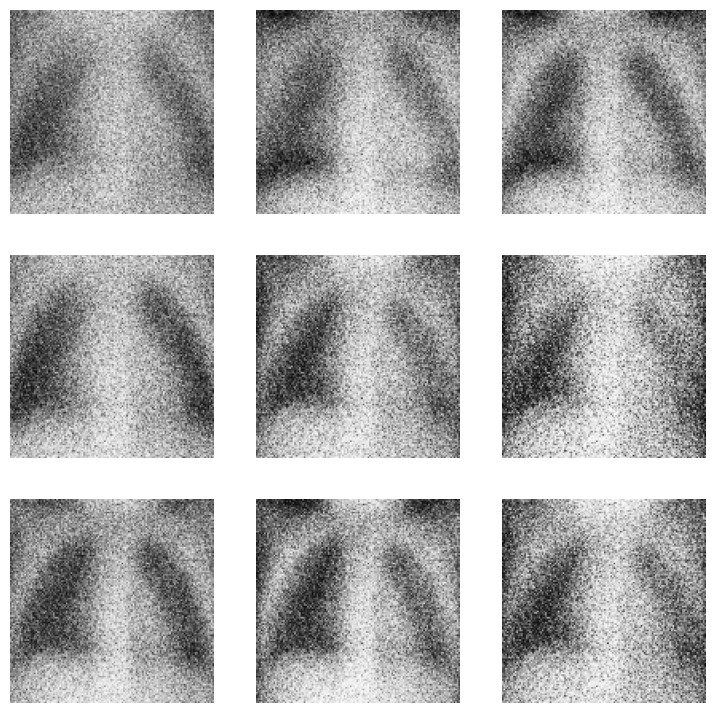

In [8]:
nrows, ncols = (3, 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3 * ncols))

for row in range(nrows):
    for col in range(ncols):
        z = torch.randn(1, latent_size).to(device)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, 1))).to(device)
        output = model.generator(z,fake_labels).reshape(image_size, image_size).detach().cpu()
        axes[row, col].imshow(output.squeeze(), cmap='gray')
        axes[row, col].axis('off')

plt.show()
transform = T.ToPILImage()

for i in range(10):
    z = torch.randn(1, latent_size).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 1, 1))).to(device)
    output = model.generator(z,fake_labels).reshape(image_size, image_size).detach().cpu()
    output = transform(output.squeeze())
    output.save(os.path.join(sys.path[0], f"output_data/NORMAL/img{i}.jpeg"))
    

for i in range(10):
    z = torch.randn(1, latent_size).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(1, 2, 1))).to(device)
    output = model.generator(z,fake_labels).reshape(image_size, image_size).detach().cpu()
    output = transform(output.squeeze())
    output.save(os.path.join(sys.path[0], f"output_data/PNEUMONIA/img{i}.jpeg"))

In [9]:
!python -m pytorch_fid output_data/NORMAL image_data/cleaned_test/NORMAL

FID:  456.2948563294046



100%|##########| 1/1 [00:07<00:00,  7.02s/it]

100%|##########| 5/5 [00:05<00:00,  1.06s/it]


In [10]:
!python -m pytorch_fid output_data/PNEUMONIA image_data/cleaned_test/PNEUMONIA

FID:  508.05958838797017



100%|##########| 1/1 [00:04<00:00,  4.67s/it]

100%|##########| 8/8 [00:05<00:00,  1.50it/s]
